In [11]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import datetime as datetime
from bs4 import BeautifulSoup as bs
import requests
import sys
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

now = datetime.datetime.today()
ido = str(now.hour)+':'+str(now.minute)
now = str(now.month)+'/'+str(now.day)+'/'+str(now.year)[2:]


DATA_URL = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/"
FILE_C = "time_series_covid19_confirmed_global.csv"
FILE_D = "time_series_covid19_deaths_global.csv"
FILE_R = "time_series_covid19_recovered_global.csv"
country_table = {'United Kingdom': 'UK', 'United Arab Emirates': 'UAE', 'USA': 'US', 'Cote d\'Ivoire': 'Ivory Coast',
                 'Congo (Brazzaville)': 'Congo', 'Saint Vincent and the Grenadines': 'St. Vincent Grenadines',
                 'Korea, South': 'S. Korea', 'Taiwan*': 'Taiwan'}
the_country = 'Hungary'

In [12]:
def load_data(the_file, country):
    data = pd.read_csv(the_file)
    lowercase = lambda x: str(x).lower()
    data.rename(lowercase, axis="columns", inplace=True)
    data.rename(columns={'country/region':'country', 'province/state':'state'}, inplace=True)
    data.fillna(0, inplace=True)
    data = data[data['country'] == country]
    data = data[data.state == 0]
    data = data.groupby(['country']).sum()
    data = data.iloc[:,4:].T
    data = data[(data.T != 0).any()]
    data.rename(columns={data.columns[0]: 'Eset'}, inplace=True)
    return data

def str2int(s):
    if s == ' ':
        return 0
    s = s.replace(',','')
    return int(s) 

In [13]:
df_d = load_data(DATA_URL + FILE_D, the_country) # Halottak
df_r = load_data(DATA_URL + FILE_R, the_country) # Gyógyultak
df_c = load_data(DATA_URL + FILE_C, the_country) # Esetek
df = pd.DataFrame()
df['Eset'] = df_c['Eset']
df['Gyógyult'] = df_r['Eset']
df['Halott'] = df_d['Eset']
dfT = df.T
df

,Eset,Gyógyult,Halott
3/4/20,2,NaN,NaN
3/5/20,2,NaN,NaN
3/6/20,2,NaN,NaN
3/7/20,4,NaN,NaN
3/8/20,7,NaN,NaN
3/9/20,9,NaN,NaN
3/10/20,9,NaN,NaN
3/11/20,13,NaN,NaN
3/12/20,13,NaN,NaN
3/13/20,19,NaN,NaN


In [14]:
if the_country == 'Hungary':
    url='https://koronavirus.gov.hu/'
    page = requests.get(url)
    soup = bs(page.content, 'html.parser')
    c = soup.find_all(class_ = 'number')
    eset = int(c[0].text)
    gyogyult = int(c[1].text)

    page = requests.get(url+'/elhunytak')
    soup = bs(page.content, 'html.parser')
    c = soup.find(class_ = 'views-row-last')
    c = c.find(class_ = 'views-field-field-elhunytak-sorszam')
    halott = int(c.text)
    dfT[now] = [eset, gyogyult, halott]
else:
    if the_country in country_table:
        the_country = country_table[the_country]
    url = 'https://www.worldometers.info/coronavirus/#countries'
    page = requests.get(url)
    soup = bs(page.content, 'html.parser')
    tbl = soup.find(id='main_table_countries_today')
    tbl = tbl.findAll('tr')
    eset = -1
    for tr in tbl:
        if the_country in tr.text:
            tds = tr.findAll('td')
            eset = str2int(tds[1].text)
            halott = str2int(tds[3].text)
            gyogyult = str2int(tds[5].text)
            break
    if eset > -1:
        dfT[now] = [eset, gyogyult, halott]
    else:
        print(f'{the_country} is not on [page]({url}).')


dfT[now] = [eset, gyogyult, halott]
df = dfT.T

df.fillna(0, inplace= True)
df['Aktív'] = df['Eset']-df['Gyógyult'] - df['Halott']
df = df.astype(int)
df.tail()

,Eset,Gyógyult,Halott,Aktív
3/28/20,343,34,11,298
3/29/20,408,34,13,361
3/30/20,447,34,15,398
3/31/20,492,37,16,439
4/1/20,525,40,20,465


In [15]:
df = df.reset_index()
df.rename(columns = {'index': 'Dátum'}, inplace=True)
df['Dátum'] = pd.to_datetime(df['Dátum'])
df.set_index(['Dátum'], drop=True, inplace=True)

df['Aktív'] = df['Eset']-(df['Gyógyult']+df['Halott'])
df['Eset+'] = df['Eset'].shift(1)
df['Halott+'] = df['Halott'].shift(1)
df.fillna(0, inplace=True)
df['EsetD'] = abs(df['Eset'] - df['Eset+'])
df['HalottD'] = abs(df['Halott'] - df['Halott+'])
df = df.astype(int)
df

,Eset,Gyógyult,Halott,Aktív,Eset+,Halott+,EsetD,HalottD
Dátum,,,,,,,,
2020-03-04,2,0,0,2,0,0,2,0
2020-03-05,2,0,0,2,2,0,0,0
2020-03-06,2,0,0,2,2,0,0,0
2020-03-07,4,0,0,4,2,0,2,0
2020-03-08,7,0,0,7,4,0,3,0
2020-03-09,9,0,0,9,7,0,2,0
2020-03-10,9,0,0,9,9,0,0,0
2020-03-11,13,0,0,13,9,0,4,0
2020-03-12,13,0,0,13,13,0,0,0


Image saved as: hungary.png


c:\users\molla\appdata\local\programs\python\python36-32\lib\site-packages\matplotlib\figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


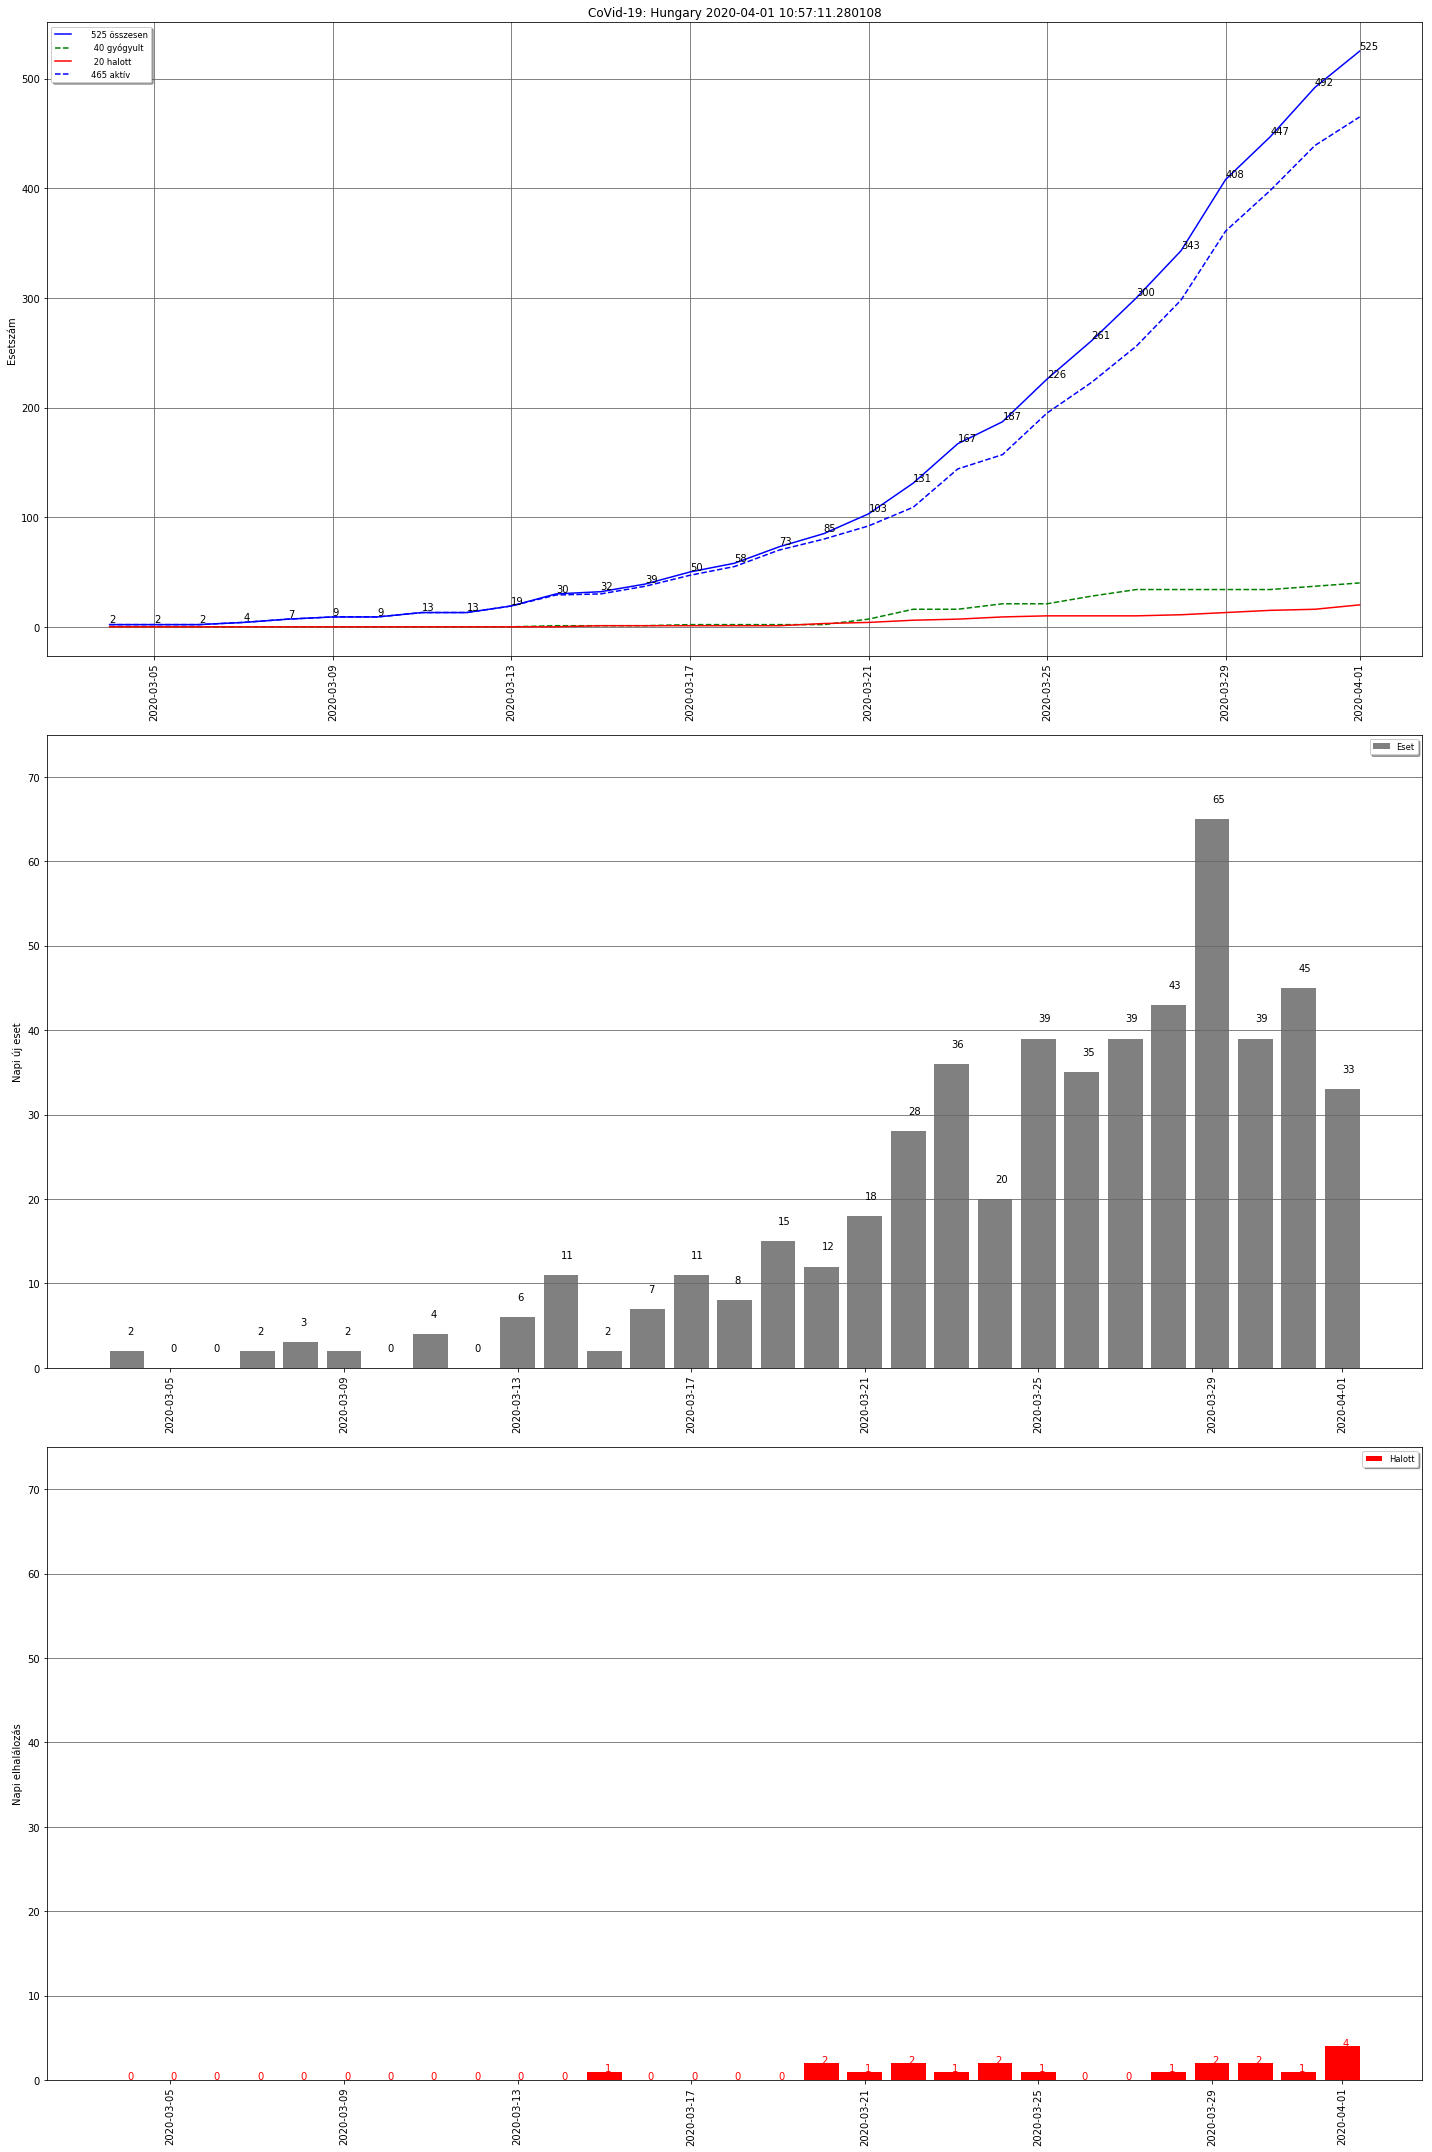

In [16]:
plt.figure(figsize=(20,30), tight_layout=True)

ax = plt.subplot(311, frameon=True)
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.plot(df.index, df['Eset'], 'b-',     label=f"{df['Eset'].max():8} összesen")
plt.plot(df.index, df['Gyógyult'], 'g--', label=f"{df['Gyógyult'].max():8} gyógyult")
plt.plot(df.index, df['Halott'], 'r-',    label=f"{df['Halott'].max():8} halott")
plt.plot(df.index, df['Aktív'], 'b--',    label=f"{df['Aktív'].max():8} aktív")

for i,j in df.Eset.items():
    ax.annotate(str(j), xy=(i, j + 2))

plt.ylabel('Esetszám')
plt.title(f'CoVid-19: {the_country} {datetime.datetime.today()}')
plt.legend(shadow=True, fontsize='small')
plt.xticks(rotation='vertical')

bx = plt.subplot(312, frameon=True)
plt.grid(axis='y', which='major', color='#666666', linestyle='-')
plt.bar(df.index, df['EsetD'], label='Eset', color='gray')
plt.ylabel('Napi új eset')
plt.ylim(0,df['EsetD'].max() + 10)
plt.xticks(rotation='vertical')
plt.legend(shadow=True, fontsize='small')

for i,j in df.EsetD.items():
    bx.annotate(j, xy=(i, j + 2))

cx = plt.subplot(313, frameon=True)
plt.grid(axis='y', which='major', color='#666666', linestyle='-')
plt.ylabel('Napi elhalálozás')
plt.ylim(0,df['EsetD'].max() + 10)
plt.bar(df.index, df['HalottD'], label='Halott', color='red')
plt.xticks(rotation='vertical')
plt.legend(shadow=True, fontsize='small')

for i,j in df.HalottD.items():
    cx.annotate(j, xy=(i, j + 0.05), color='red')

plt.savefig(f'{the_country.lower()}.png')
print(f'Image saved as: {the_country.lower()}.png')
# plt.show()
